🔄 Cargando datos para el análisis de explicabilidad...
🧹 Filas antes de limpiar: 5615
✅ Filas después de limpiar: 5162
📂 Cargando modelo desde: models\xgb_model.json
✅ Modelo cargado exitosamente.
⚙️ Generando explicaciones SHAP (esto puede tardar unos segundos)...

📊 Generando Figura 4: Summary Plot...


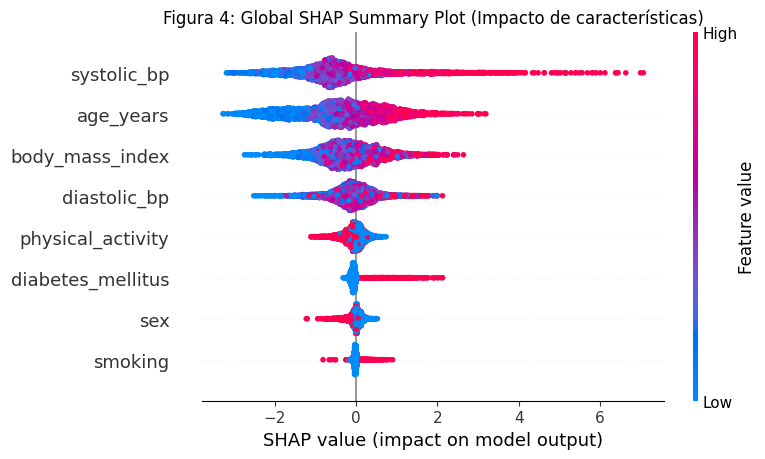


📊 Generando Figura 5: Global Feature Importance...


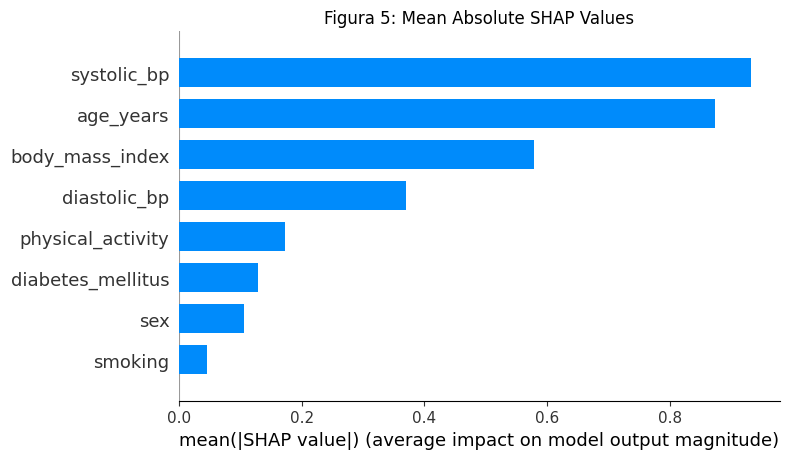


📊 Generando Figura 7: Dependence Plots...


<Figure size 800x500 with 0 Axes>

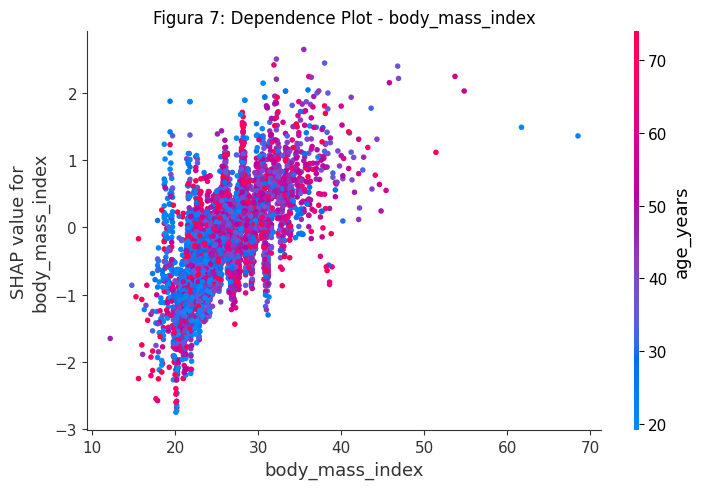

<Figure size 800x500 with 0 Axes>

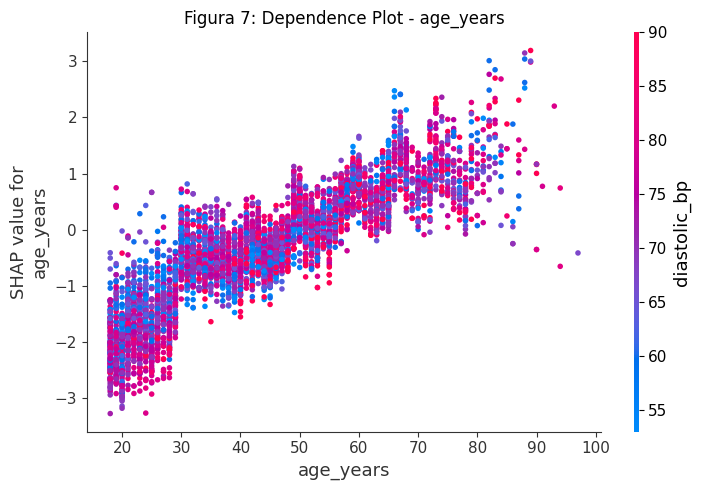

<Figure size 800x500 with 0 Axes>

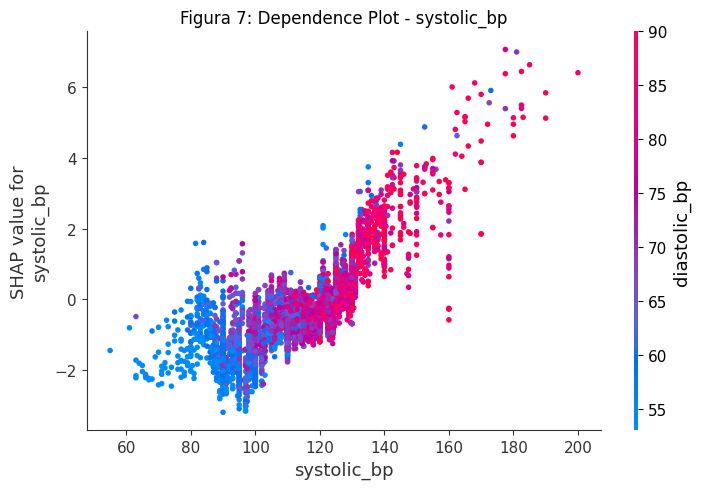


📊 Generando Figura 6: Force Plots (Ejemplos Locales)...
   -> Graficando paciente índice 0


<Figure size 1500x300 with 0 Axes>

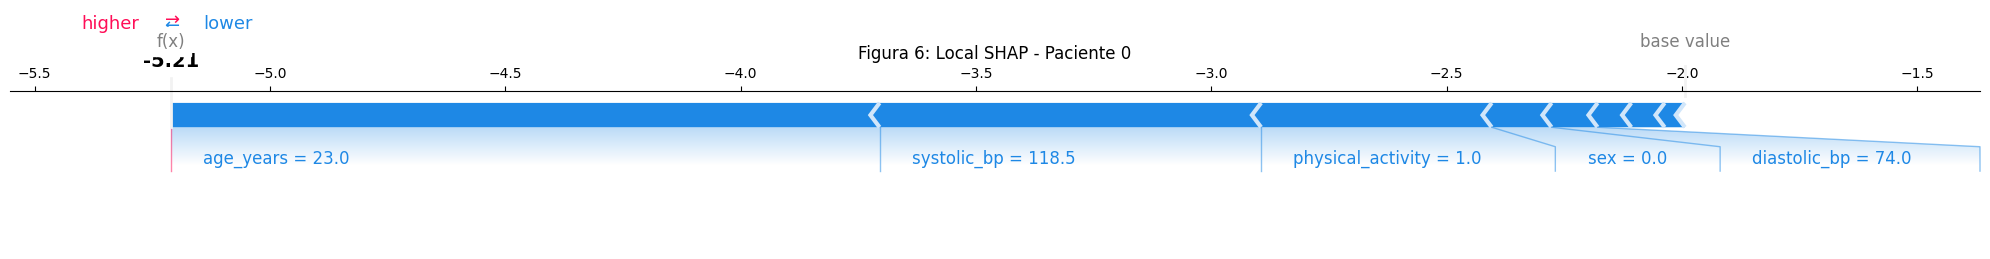

   -> Graficando paciente índice 10


<Figure size 1500x300 with 0 Axes>

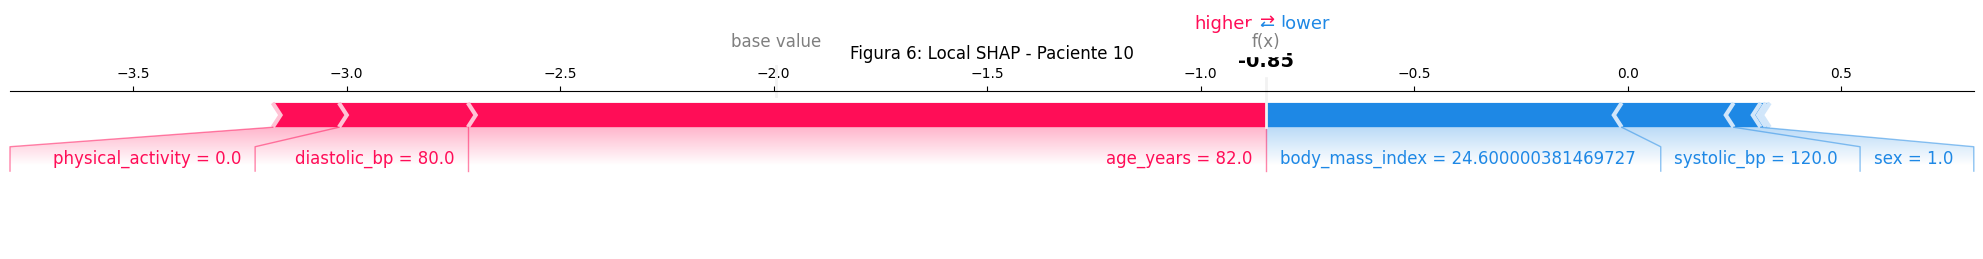

In [ ]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import os
import numpy as np

# Importaciones de tu configuración y preparación de datos
from src.config import settings
from src.data_preparation import DataPreparation


def run_analysis():
  # 1. Obtener los datos (X) para el explicador
  print("🔄 Cargando datos para el análisis de explicabilidad...")
  try:
    data_prep = DataPreparation()
    df = data_prep.get_output()
    X = df.drop(columns=[settings.FEATURE_TARGET])
    # Nota: Asegúrate de que las columnas en X coincidan con las del entrenamiento
  except Exception as e:
    print(f"❌ Error al cargar los datos: {e}")
    return

  # 2. Cargar el modelo guardado
  model_filename = "xgb_model.json"
  model_path = os.path.join(settings.MODEL_PATH, model_filename)

  print(f"📂 Cargando modelo desde: {model_path}")
  model = xgb.XGBClassifier()

  if not os.path.exists(model_path):
    print(f"❌ No se encontró el archivo del modelo en {model_path}. Asegúrate de haberlo entrenado primero.")
    return

  try:
    model.load_model(model_path)
    print("✅ Modelo cargado exitosamente.")
  except Exception as e:
    print(f"❌ Error al cargar el modelo con XGBoost: {e}")
    return

  # 3. Calcular valores SHAP (Réplica de la metodología del paper)
  print("⚙️ Generando explicaciones SHAP (esto puede tardar unos segundos)...")
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X)

  # 4. Generación de Gráficas

  # --- FIGURA 4: Global SHAP Summary Plot (Puntos) ---
  # Muestra la distribución del impacto de cada característica [cite: 350]
  print("\n📊 Generando Figura 4: Summary Plot...")
  plt.figure(figsize=(10, 6))
  shap.summary_plot(shap_values, X, show=False)
  plt.title("Figura 4: Global SHAP Summary Plot (Impacto de características)")
  plt.tight_layout()
  plt.show()

  # --- FIGURA 5: Global Importance (Barras) ---
  # Muestra la magnitud media absoluta del impacto [cite: 430]
  print("\n📊 Generando Figura 5: Global Feature Importance...")
  plt.figure(figsize=(10, 6))
  shap.summary_plot(shap_values, X, plot_type="bar", show=False)
  plt.title("Figura 5: Mean Absolute SHAP Values")
  plt.tight_layout()
  plt.show()

  # --- FIGURA 7: Dependence Plots ---
  # El paper analiza Htmed, HL, Age, B12. Intentaremos graficar esas si existen. [cite: 720]
  print("\n📊 Generando Figura 7: Dependence Plots...")
  target_features = ['Htmed', 'HL', 'age', 'B12']  # Nombres usados en el paper

  # Filtramos solo las que existan en tu dataset actual
  features_to_plot = [f for f in target_features if f in X.columns]

  # Si no coinciden los nombres, tomamos las 3 más importantes automáticamente
  if not features_to_plot:
    mean_shap = np.abs(shap_values).mean(axis=0)
    top_indices = np.argsort(mean_shap)[-3:]
    features_to_plot = X.columns[top_indices].tolist()

  for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    shap.dependence_plot(feature, shap_values, X, show=False)
    plt.title(f"Figura 7: Dependence Plot - {feature}")
    plt.tight_layout()
    plt.show()

  # --- FIGURA 6: Local SHAP (Force Plots) ---
  # Análisis de casos individuales (Pacientes específicos) [cite: 616]
  print("\n📊 Generando Figura 6: Force Plots (Ejemplos Locales)...")
  # Tomamos el primer paciente y el décimo como ejemplos
  sample_indices = [0, 10] if len(X) > 10 else [0]

  # Nota: shap.force_plot usa JS por defecto. Para scripts usamos matplotlib=True
  for i in sample_indices:
    print(f"   -> Graficando paciente índice {i}")
    plt.figure(figsize=(15, 3))
    shap.force_plot(
        explainer.expected_value,
        shap_values[i],
        X.iloc[i],
        matplotlib=True,
        show=False
    )
    plt.title(f"Figura 6: Local SHAP - Paciente {i}")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
  run_analysis()
